In [1]:
import pandas as pd
import requests
import datetime
import shutil
import errno
import os

savepath = "datasets/"

In [2]:
# Renfe Horarios de alta velocidad, larga distancia y media distancia
url = 'https://ssl.renfe.com/gtransit/Fichero_AV_LD/google_transit.zip'

flags = os.O_CREAT | os.O_EXCL | os.O_WRONLY

# Download zip file
req = requests.get(url)

# Get file name from url
filename = url.split('/')[-1]

if not os.path.exists(savepath):
   os.makedirs(savepath)

try:
    file_handle = os.open(savepath+filename, flags)
except OSError as e:
    if e.errno == errno.EEXIST:  # Failed as the file already exists.
        print('File already exists!')
    else:  # Something unexpected went wrong so reraise the exception.
        raise
else:  # No exception, so the file must have been created successfully.
    # Writing the file to the local file system
    with open(savepath+filename, 'wb') as output_file:
        output_file.write(req.content)

    # Unzip
    shutil.unpack_archive(savepath+filename, savepath)

    print('File downloaded successfully!')

File already exists!


In [3]:
renfe_schedules = {}

for filename in os.listdir(savepath):
    if filename.endswith('.txt'):
        renfe_schedules[filename.split(".")[0]] = pd.read_csv(savepath+filename, delimiter=',')

In [4]:
renfe_schedules['stops']

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,71801,NaN,Barcelona-Sants,NaN,41.379220,2.140624,NaN,NaN,NaN,NaN,Europe/Madrid,1
1,61307,NaN,Cartagena,NaN,37.604967,-0.975122,NaN,NaN,NaN,NaN,Europe/Madrid,1
2,61304,NaN,Torre-Pacheco,NaN,37.746905,-0.967078,NaN,NaN,NaN,NaN,Europe/Madrid,2
3,61303,NaN,Balsicas-Mar Menor,NaN,37.818840,-0.950891,NaN,NaN,NaN,NaN,Europe/Madrid,2
4,61200,NaN,Murcia,NaN,37.974650,-1.129955,NaN,NaN,NaN,NaN,Europe/Madrid,1
...,...,...,...,...,...,...,...,...,...,...,...,...
797,34008,NaN,Narros del Castillo,NaN,40.866641,-5.052869,NaN,NaN,NaN,NaN,Europe/Madrid,2
798,34007,NaN,Crespos,NaN,40.870110,-4.968030,NaN,NaN,NaN,NaN,Europe/Madrid,2
799,34005,NaN,San Pedro del Arroyo,NaN,40.803841,-4.871407,NaN,NaN,NaN,NaN,Europe/Madrid,2
800,34002,NaN,Cardenyosa de Avila,NaN,40.739120,-4.750750,NaN,NaN,NaN,NaN,Europe/Madrid,2


In [5]:
df = renfe_schedules['stops']

stopsD = dict(zip(df.stop_name, zip(df.stop_id, zip(df.stop_lat, df.stop_lon))))

stopsD['Murcia']

(61200, (37.97465, -1.1299555))

In [6]:
# Install cartopy - if necessary via IDE
#!pip install cartopy==0.18.0

# Install geopandas - if necessary
#!pip install geopandas

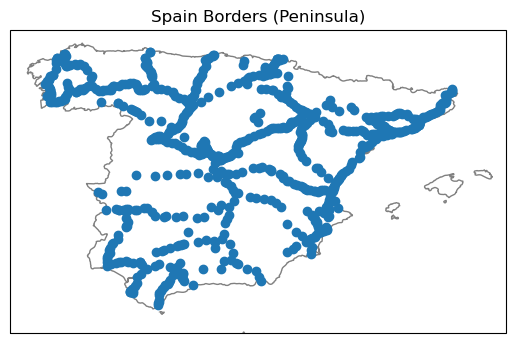

In [9]:
from cartopy.io import shapereader
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas

# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shapefilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shapefilename)

# read Spain borders
poly = df.loc[df['ADMIN'] == 'Spain']['geometry'].values[0]

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries([poly], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='0.5')

# Scatter plot each station (lat, lon)
stopsCoords = [(float(stopsD[s][1][1]), float(stopsD[s][1][0])) for s in stopsD]
x, y = zip(*stopsCoords)
ax.scatter(x, y)

bounds= poly.bounds # minx, miny, maxx, maxy
# (-18.167225714999915, 27.642238674000055, 4.337087436000047, 43.79344310100004)
bounds = list(bounds)
bounds[0] = -9.4
bounds[1] = 35.7
m = 0.4 # Margin
bounds = [l - m if i < 2 else l + m for i, l in enumerate(bounds)]

ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]])

ax.set_title("Spain Borders (Peninsula)")
plt.show()